In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
###################################################################################
###         convert dates and times of manual controls to timestamps            ###
###################################################################################

year = 2021
month = 5
day = [5, 5, 6, 7, 8, 9, 10, 11, 13, 18, 14]
hour = [0, 20, 10, 8, 10, 13, 9, 16, 11, 12, 0]
minutes = [13, 13, 46, 27, 40, 20, 0, 24, 50, 15, 0]
seconds = 0
timestamps = []

if len(day) == len(hour) == len(minutes):
    for i in range(len(day)):
        time = datetime(year, month, day[i], hour[i], minutes[i], seconds)
        timestamp = time.timestamp()
        timestamps.append(timestamp)
        print(time, 'hat den Timestamp', timestamp)

else:
    print('ungleiche Zahl an Tagen, Stunden & Minuten')

2021-05-05 00:13:00 hat den Timestamp 1620166380.0
2021-05-05 20:13:00 hat den Timestamp 1620238380.0
2021-05-06 10:46:00 hat den Timestamp 1620290760.0
2021-05-07 08:27:00 hat den Timestamp 1620368820.0
2021-05-08 10:40:00 hat den Timestamp 1620463200.0
2021-05-09 13:20:00 hat den Timestamp 1620559200.0
2021-05-10 09:00:00 hat den Timestamp 1620630000.0
2021-05-11 16:24:00 hat den Timestamp 1620743040.0
2021-05-13 11:50:00 hat den Timestamp 1620899400.0
2021-05-18 12:15:00 hat den Timestamp 1621332900.0
2021-05-14 00:00:00 hat den Timestamp 1620943200.0


In [3]:
###################################################
###         read all data form log-file         ###
###################################################

file_data = 'C:\\Users\Jan\GitRepos\data\Sud1.json'

time=[]
pressure=[]
airflow=[]
with open (file_data) as f:
    for line in f:
        fermentation = json.loads(line)
        time.append(fermentation['Timestamp'])
        pressure_dict=fermentation['pressure']
        pressure.append(pressure_dict['bar'])
        airflow_dict = fermentation['airflow']
        airflow.append(airflow_dict['flow'])

###########################################################
###         transofrm data into numpy arrays            ###
###########################################################

time = np.array(time)
time = np.multiply(0.001, time).round(decimals=0)   # transform timestamps from milliseconds to seconds
pressure = np.array(pressure)
airflow = np.array(airflow)

print('time shape:', time.shape)
print('pressure shape:', pressure.shape)
print('airflow shape:', airflow.shape)

time shape: (270352,)
pressure shape: (270352,)
airflow shape: (270352,)


In [4]:
#######################################################
###         find first and last timestamp           ###
#######################################################

print(np.where(time==1620166381)[0][0])             # zeigt Position des ersten Wertes an -> bis hier werden die Werte der Arrays gelöscht
print(time[-1])                                     # zeigt dass die letzte digitale Messung vor der letzten manuellen Messung stattfand -> Arrays bleiben bis zum Ende erhalten

38773
1621328577.0


In [5]:
####################################################################################
###         delete first values of arrays before start of fermentation           ###
####################################################################################

time = time[38773:]
pressure = pressure[38773:]
airflow = airflow[38773:]
print(time[0])                                      # prüfe, dass wirklich mit richtigem timestamp gestartet wird

1620166381.0


In [6]:
#####################################################################################
###         calculations with arrays to create more arrays of input data          ###
#####################################################################################


# ----------------------------------------------------------------

time_seconds = time - 1620166381                                               # first timestamp should be zero
time_days = np.multiply(1.157416667e-5, time_seconds).round(decimals=5)

print('time_seconds:', time_seconds[:4])
print('time_days:', time_days[:4])

# ----------------------------------------------------------------

# airflow = airflow.clip(min=0)                       # set negativ values to zero
# airflow = np.multiply(0.1, airflow)                                           # Anpassung an benötigten Verlauf
print(np.where(time==1620899399)[0][0])             # zeigt Position nach knapp 9 Tagen, danach wird airflow auf 0 gesetzt.
airflow[146003:] = 0
print(airflow[146001:146005])
airflow_5s = np.multiply(0.0833333333333, airflow).round(decimals=2)        # *(5/60) -> Standart Liter per 5 secondes
airflow_sum = np.cumsum(airflow_5s)                                         # sum up all values of airflow in airflow_sum

time_seconds: [ 0.  5. 10. 15.]
time_days: [0.0e+00 6.0e-05 1.2e-04 1.7e-04]
146003
[1.382446 1.397705 0.       0.      ]


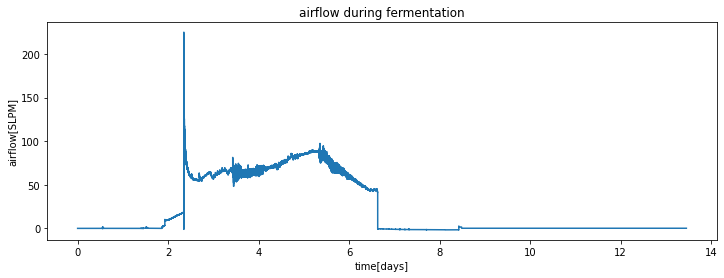

In [7]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days, airflow)
plt.xlabel('time[days]')
plt.ylabel('airflow[SLPM]')
plt.show()

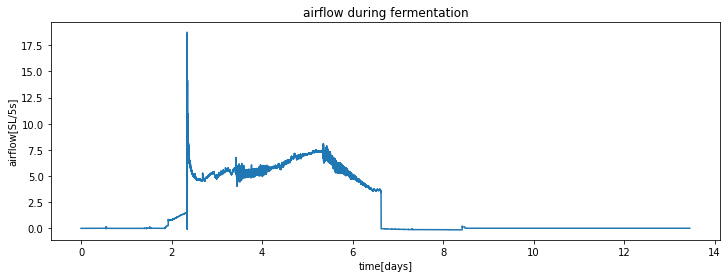

In [8]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days,airflow_5s)
plt.xlabel('time[days]')
plt.ylabel('airflow[SL/5s]')
plt.show()

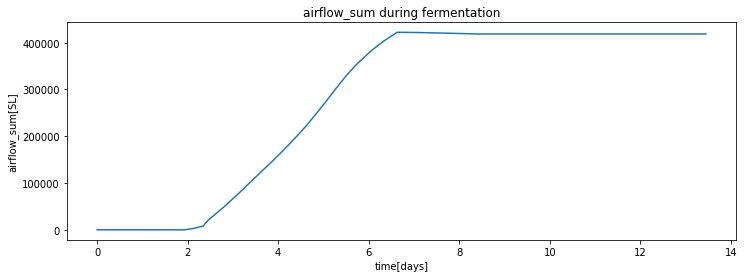

In [9]:
plt.figure(figsize=(12,4))
plt.title('airflow_sum during fermentation')
plt.plot(time_days,airflow_sum)
plt.xlabel('time[days]')
plt.ylabel('airflow_sum[SL]')
plt.show()

In [10]:
##############################################
###         !!! Kontrollrechnung !!!       ###
##############################################

# Wir haben ca. 250 kg Extrakt
Extrakt = 250

# Etwa 2/3 des Extrakts vergären
vergoren = Extrakt * 0.66

# vergorener Exktrakt wird zu 46,3% zu CO2
CO2 = vergoren * 0.463

# 15% des CO2 bleiben im Bier gebunden
CO2_air = CO2 * 0.85

# 1 Liter CO2 wiegt 1,96g
# --> 1kg CO2 entsprechen ca. 510 Liter
CO2_volume = CO2_air * 510

# 1000 Liter Platz im Tank
CO2_volume_outside = CO2_volume - 1000


print('vergorener Extrakt:', vergoren, 'kg')
print('CO2 Masse gesamt:', CO2, 'kg')
print('CO2 Masse NICHT im Bier gebunden:', CO2_air, 'kg')
print('CO2 Volumen:', CO2_volume, 'Liter')
print('CO2 Volumen durch den Sensor:', CO2_volume_outside, 'Liter\n')

print('Aus dem Tank ausgeströmter CO2:', airflow_sum[-1], 'Liter')

vergorener Extrakt: 165.0 kg
CO2 Masse gesamt: 76.39500000000001 kg
CO2 Masse NICHT im Bier gebunden: 64.93575000000001 kg
CO2 Volumen: 33117.232500000006 Liter
CO2 Volumen durch den Sensor: 32117.232500000006 Liter

Aus dem Tank ausgeströmter CO2: 418781.6499997742 Liter


In [11]:
###########################################
###         Extraktberechnung           ###
###########################################


# ----------------------------------------------------------------
#           create arrays full of ones

flow_mass_sum = np.full_like(time_days, 1)
gas_in_liquid_mass = np.full_like(time_days, 1)
total_co2_mass = np.full_like(time_days, 1)
extract_mass_converted = np.full_like(time_days, 1)
extraktgehalt = np.full_like(time_days, 1)
extraktgehalt_scheinbar = np.full_like(time_days, 1)

# ----------------------------------------------------------------
#           constants for fermentation calculation

SW = 11.9                                          # Stammwürze [°P]
wuerze_mass = 2080                                 # mass of wort [kg]
extract_mass_start = SW * wuerze_mass / 100        # mass of extract at before fermentation [kg]
air_volume = 1000                                  # volume in tank above liquid [l]
air_mass = air_volume * 0.00196                    # mass of CO2 in tank above liquid [kg]
 
# ----------------------------------------------------------------

print('mass of extract before fermantation:', extract_mass_start, 'kg')
print('mass of CO2 above liquid in tank:', air_mass, 'kg')

mass of extract before fermantation: 247.52 kg
mass of CO2 above liquid in tank: 1.96 kg


In [12]:
# ----------------------------------------------------------------------------------------
#           loop over every step (every 5 seconds) during fermantation

for i in range(len(extraktgehalt)):

    flow_mass_sum[i] = airflow_sum[i] * 0.00196                                    # mass of all CO2 outside the tank
    gas_in_liquid_mass[i] = (flow_mass_sum[i] + air_mass ) * 0.17647               # 15% of CO2 stays in liquid
    total_co2_mass[i] = flow_mass_sum[i] + air_mass + gas_in_liquid_mass[i]        # sum of all CO2 parts [kg]

    extract_mass_converted[i] = total_co2_mass[i] / 0.463                                                             # converted extract [kg]
    extraktgehalt[i] = (extract_mass_start - extract_mass_converted[i]) * 100 / (wuerze_mass - flow_mass_sum[i])      # extract in beer [Gew.-%]

    extraktgehalt_scheinbar[i] = (extraktgehalt[i] - (0.1808*SW))/0.8192                           # scheinbarer Extraktgehalt [°P]

# -----------------------------------------------------------------------------------------

print('mass of total CO2 flow (outside tank) after fermantation:', flow_mass_sum[-1], 'kg')
print('mass of CO2 above liquid in tank:', air_mass, 'kg')
print('mass of CO2 in liquid after fermantation:', gas_in_liquid_mass[-1], 'kg')
print('total mass of CO2 after fermantation:', total_co2_mass[-1], 'kg')
print('\n')
print('Extraktgehalt shape:', extraktgehalt.shape)
print('Extraktgehalt Start:', extraktgehalt[0])
print('Extraktgehalt Ende:', extraktgehalt[-1])






mass of total CO2 flow (outside tank) after fermantation: 820.8120339995573 kg
mass of CO2 above liquid in tank: 1.96 kg
mass of CO2 in liquid after fermantation: 145.19458083990187 kg
total mass of CO2 after fermantation: 967.9666148394592 kg


Extraktgehalt shape: (231579,)
Extraktgehalt Start: 11.660564545671944
Extraktgehalt Ende: -146.3737493185064


In [13]:
###########################################
###         plot data over time         ###
###########################################

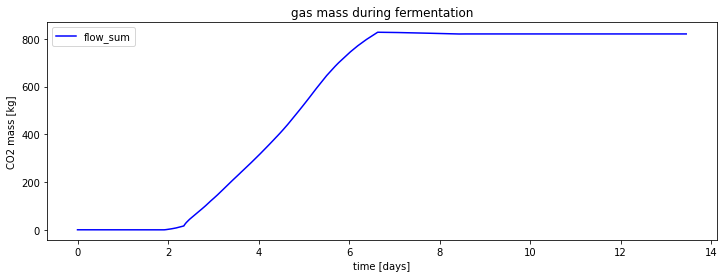

In [14]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, flow_mass_sum, color="blue", label="flow_sum")
plt.xlabel('time [days]')
plt.ylabel('CO2 mass [kg]')
plt.legend()
plt.show()

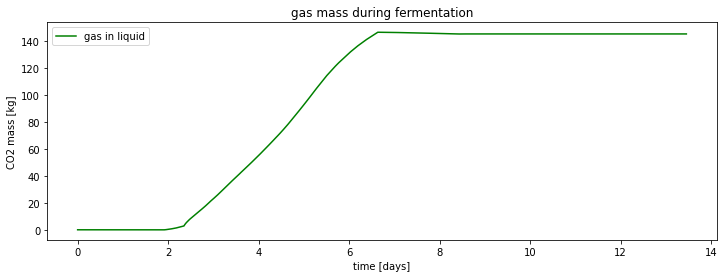

In [15]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, gas_in_liquid_mass, color="green", label="gas in liquid")
plt.xlabel('time [days]')
plt.ylabel('CO2 mass [kg]')
plt.legend()
plt.show()

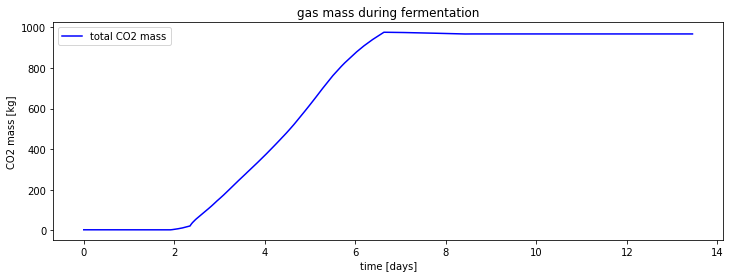

In [16]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, total_co2_mass, color="blue", label="total CO2 mass")
plt.xlabel('time [days]')
plt.ylabel('CO2 mass [kg]')
plt.legend()
plt.show()

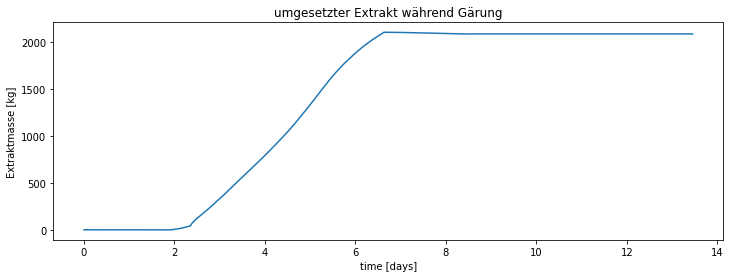

In [17]:
plt.figure(figsize=(12,4))
plt.title('umgesetzter Extrakt während Gärung')
plt.plot(time_days, extract_mass_converted)
plt.xlabel('time [days]')
plt.ylabel('Extraktmasse [kg]')
plt.show()

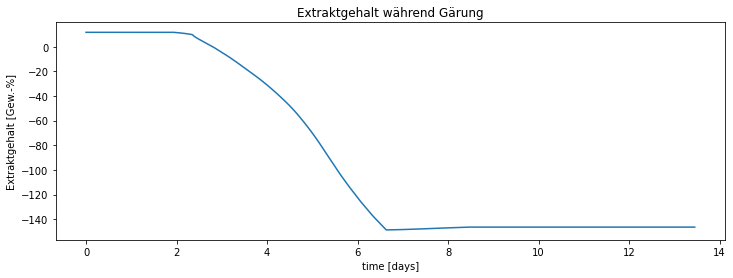

In [18]:
plt.figure(figsize=(12,4))
plt.title('Extraktgehalt während Gärung')
plt.plot(time_days, extraktgehalt)
plt.xlabel('time [days]')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.show()

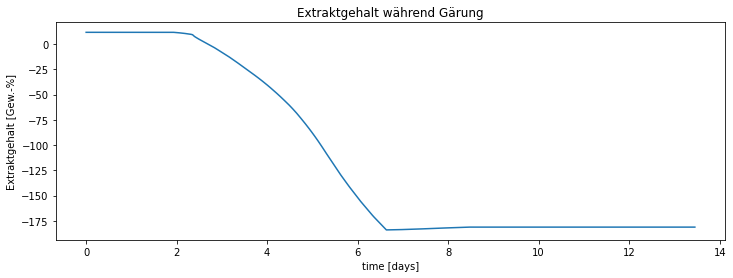

In [19]:
plt.figure(figsize=(12,4))
plt.title('Extraktgehalt während Gärung')
plt.plot(time_days, extraktgehalt_scheinbar)
plt.xlabel('time [days]')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.show()